In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wrds 

In [2]:
db = wrds.Connection(wrds_username="thomas_bienaime")
#db.create_pgpass_file()

Loading library list...
Done


In [3]:
permno=[11308, 11850, 12490, 14541, 17830, 18163, 18542, 19502, 19561, 21936, 22111, 22592, 22752, 26403, 43449, 47896, 55976, 59176, 59328, 59459]
names=['AXP', 'BA', 'CAT', 'CDX', 'DIS', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'PFE', 'PG','TRV', 'RTX','WVA', 'WMET', 'XOM']

In [4]:
tb_bills = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf where kytreasnox= 2000001 and mcaldt>='1978-01-01' and mcaldt <='2021-12-31'")
tb_bills = tb_bills.rename(
    columns ={"mcaldt" : "date", "tmytm" :"ret" })
tb_bills['ret']= np.exp(tb_bills["ret"]/(12*100)) -1

In [5]:
def weight_tang_port(mu,Sigma,R0,A,B):
    """ Calculate and return the weight of the tangeancy
        portfolio, given the estimate of the parameter
    """
    w = ((np.linalg.inv(Sigma))@(mu - R0*np.ones(Sigma.shape[0])))/(B - A*R0)
    return w
    

In [6]:
def weight_min_port(Sigma):
    """ Calculate and return the weight of the global minimum variance 
        portfolio, given the estimate of the parameter
    """
    w = (np.linalg.inv(Sigma) @ np.ones(Sigma.shape[0]))/(np.ones(Sigma.shape[0])@np.linalg.inv(Sigma)@np.ones(Sigma.shape[0]))
    return w

# b
There is no condition on it's variance and mean.
Suppose GMV is not mean-variance efficient. Then there exist a portfolio in the minimum-variance frontier, with the same variance but a higher expected return. 

By the two fund separation result,GMV is in the minimum-variance frontier and any portfolio in the minimum-variance frontier is atainable by a combination of GMV portfolio and the maximum slope portfolio. 

It implies that in the graph with expected return and standard deviation as axis, two continuous function form a continuous curve. However that would imply that the GMV is not the GMV, proof by contradiction.

In [7]:
def weight_risk_parity(Volatility):
    """ Calculate and return the weight of the Risk Parity
        portfolio, given the volatility of each stocks
    """
    
    Inv_Vol = 1/Volatility
    w = Inv_Vol/Inv_Vol.sum()
    return w

# c
The condition on the covariance matrix is that it must be a diagonal matrix, and the mean must be such that the sharp ratio is constant/same for all risky assets.

In [8]:
def weight_equally_port(n):
    """ Calculate and Return the weight of an equally weighted 
        Portfolio, given the number of stocks
    """
    return np.ones(n)/n

In [9]:
def weight_slope(mu,Sigma):
    """ Calculate and Return the weight of the slope portfolio
    """
    w = (np.linalg.inv(Sigma) @ mu)/(np.ones(Sigma.shape[0]) @ np.linalg.inv(Sigma) @ mu)
    return w

In [10]:
def create_database(name,permno):
    """ 
    Doanload the stock ask to download and return it in a DataFrame
    
    """
    data = db.raw_sql("select date, ret from crsp.msf where permno in ( "
                                  +str(permno[0])+
                                  ") and date >='1978-01-01' and date <= '2021-12-31'")
    Final_tab = data
    Final_tab=Final_tab.rename(columns={"ret": name[0]})
    #print(Final_tab)
    for i in range (1,len(permno)):
        data = db.raw_sql("select date, ret from crsp.msf where permno in ( "
                                  +str(permno[i])+
                                  ") and date >='1978-01-01' and date <= '2021-12-31'")
        
        Final_tab=pd.merge(Final_tab,data,on='date')
        Final_tab=Final_tab.rename(columns={"ret": name[i]})
    Final_tab =Final_tab.set_index(['date'])
    return Final_tab

# Beginning of the Analysis

In [11]:
Monthly_Ret = create_database(names,permno)

In [12]:
# Creation des rolling
Rolling_Mean = Monthly_Ret.rolling(120,min_periods=120,center=False).mean()
Rolling_Std = Monthly_Ret.rolling(120,min_periods=120,center=False).std()
Rolling_Cov_Matrix = Monthly_Ret.rolling(120,min_periods=120,center=False).cov()

In [13]:
# Computation of the Weight 
ones = np.ones(20)
index = Monthly_Ret.iloc[119:].index.get_level_values(0)
index_j = Monthly_Ret.iloc[120:].index.get_level_values(0)
counter = 119
Weight_Matrix = pd.DataFrame(data = {'Date': index} , 
                             columns = {'Date',
                                        'Tangency Portfolio', 
                                        'Global Minimum Portfolio' , 
                                        'Risk Parity Portfolio' , 
                                        'Equally Weighted Portfolio'} )


Return_Matrix = pd.DataFrame(data = {'Date': index_j} , 
                             columns = {'Date',
                                        'Tangency Portfolio', 
                                        'Global Minimum Portfolio' , 
                                        'Risk Parity Portfolio' , 
                                        'Equally Weighted Portfolio'} )

Ret_Slope = []


for i,j in zip(index,index_j):
    Ret = Monthly_Ret.loc[j].values
    mu = Rolling_Mean.loc[i].values
    Sigma_Matrix = Rolling_Cov_Matrix.loc[i].values
    Volatility = Rolling_Std.loc[i].values

    R0 = tb_bills["ret"][counter]
    counter = counter+1
    
    A = ones @ (np.linalg.inv(Sigma_Matrix)) @ ones.transpose()
    B = ones @ (np.linalg.inv(Sigma_Matrix)) @ mu
    C = mu.transpose() @ (np.linalg.inv(Sigma_Matrix)) @ mu
    Delta = A*C - B*B
    
    w_min = weight_min_port(Sigma_Matrix)
    w_tan = weight_tang_port(mu,Sigma_Matrix,R0,A,B)
    w_rp = weight_risk_parity(Volatility)
    w_ew = weight_equally_port(Sigma_Matrix.shape[0])
    w_slope = weight_slope(mu,Sigma_Matrix)
    
    ## Adding weight in the matrix
    Weight_Matrix['Tangency Portfolio'][counter-120] = w_tan
    Weight_Matrix['Global Minimum Portfolio'][counter-120] = w_min
    Weight_Matrix['Risk Parity Portfolio'][counter-120] = w_rp
    Weight_Matrix['Equally Weighted Portfolio'][counter-120] = w_ew
    
    
    ## Computing the Expected Return
    Return_Matrix['Tangency Portfolio'][counter-120] = w_tan @ Ret
    Return_Matrix['Global Minimum Portfolio'][counter-120] = w_min @ Ret
    Return_Matrix['Risk Parity Portfolio'][counter-120] = w_rp @ Ret
    Return_Matrix['Equally Weighted Portfolio'][counter-120] = w_ew @ Ret
    Ret_Slope.append(w_slope @ Ret)
    
    

In [14]:
print('Statistics are Annualized')
Stat_Return = Return_Matrix.agg(["mean","std"])
Stat_Return.loc["mean"] *= 12
Stat_Return.loc["std"] *= np.sqrt(12)

Statistics are Annualized


In [15]:
R_f = 12*tb_bills['ret'][120:].mean()
Sharpe_Ratio = (Stat_Return.loc["mean"]-R_f) / Stat_Return.loc["std"]
Stat_Return = Stat_Return.transpose()
Stat_Return["Sharpe Ratio"] = Sharpe_Ratio
Result = Stat_Return.transpose()

display(Result.style.format('{:.2%}'))


,Global Minimum Portfolio,Equally Weighted Portfolio,Tangency Portfolio,Risk Parity Portfolio
mean,10.52%,14.63%,5.96%,14.16%
std,13.31%,14.37%,25.79%,13.78%
Sharpe Ratio,58.52%,82.80%,12.51%,82.94%


# (f)

Our results are quite surprising since the performance of the tangency portfolio are bad. In theory the tangency portfolio must maximize the Sharpe Ratio which is not what we can observed.
The tangency portfolio poor performances can be explained by the fact that we construct it by using the mean estimator. It is not the case for all the others portfolio. The mean estimator is not accurate enough. We are also suprise by the strong result of easy model like the Equally Weighted Portfolio and Risk Parity Portfolio

# (g)

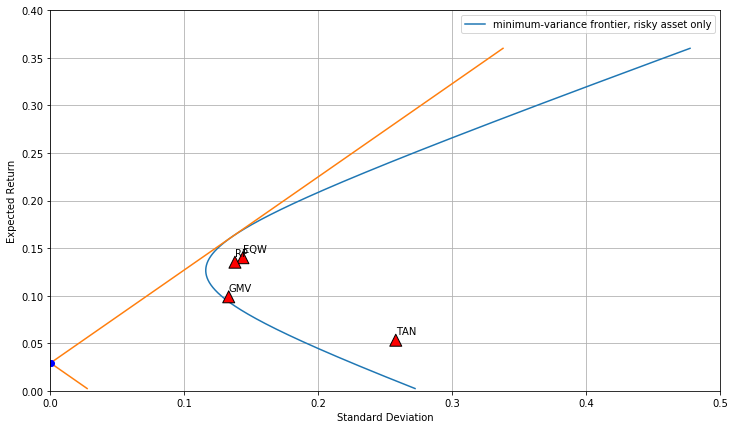

In [16]:
N=10000

#MV frontiers
Mup = np.linspace(0.0002,0.030,N)
new_index = Monthly_Ret.iloc[120:492].index.get_level_values(0)
mu = Monthly_Ret.loc[new_index].mean().values
Sigma = Monthly_Ret.loc[new_index].cov().values
Inv_Sigma = np.linalg.inv(Sigma)
ones = np.ones(Sigma.shape[0])

A = ones @ Inv_Sigma @ ones.transpose()
B = ones @ Inv_Sigma @ mu
C = mu.transpose() @ Inv_Sigma @ mu
Delta = A*C - B*B

rf = tb_bills['ret'][120:492].mean()

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/Delta)
Sigmap2 = np.sqrt((Mup-rf)**2/(C - 2*rf*B + rf*rf*A))


plt.figure(figsize=(12,7))
plt.plot(Sigmap*np.sqrt(12),Mup*12, label = "minimum-variance frontier, risky asset only")
plt.plot(Sigmap2*np.sqrt(12),Mup*12)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(0.0001,tb_bills['ret'][120:492].mean()*12,'bo')
plt.xlim(0, 0.5)
plt.ylim(0,0.4)

plt.annotate('GMV',(Result['Global Minimum Portfolio'][1],Result['Global Minimum Portfolio'][0]),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.annotate('TAN',(Result['Tangency Portfolio'][1],Result['Tangency Portfolio'][0]),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.annotate('EQW',(Result['Equally Weighted Portfolio'][1],Result['Equally Weighted Portfolio'][0]),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.annotate('RP',(Result['Risk Parity Portfolio'][1],Result['Risk Parity Portfolio'][0]),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.grid()
plt.legend()


# (h)

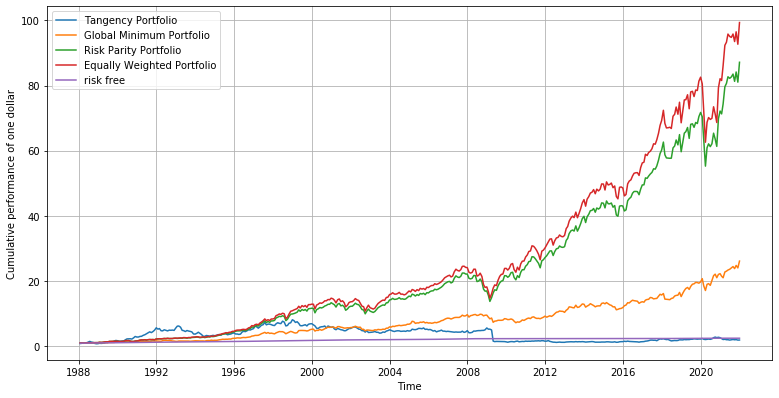

In [17]:
cumulative_return = pd.DataFrame(index = index_j )
cumulative_return['Tangency Portfolio'] = (Return_Matrix['Tangency Portfolio']+1).cumprod().to_numpy()
cumulative_return['Global Minimum Portfolio'] = (Return_Matrix['Global Minimum Portfolio']+1).cumprod().to_numpy()
cumulative_return['Risk Parity Portfolio'] = (Return_Matrix['Risk Parity Portfolio']+1).cumprod().to_numpy()
cumulative_return['Equally Weighted Portfolio'] = (Return_Matrix['Equally Weighted Portfolio']+1).cumprod().to_numpy()
cumulative_return["risk free"] = (tb_bills['ret'][120:]+1).cumprod().to_numpy()
cumulative_return.plot(figsize=(13,6.5))
plt.xlabel('Time')
plt.ylabel('Cumulative performance of one dollar')
plt.legend()
plt.grid()

In [18]:
print("The cumulative performance of each strategy are :")
display(cumulative_return.iloc[-1])

The cumulative performance of each strategy are :


Tangency Portfolio             1.975253
Global Minimum Portfolio      26.170645
Risk Parity Portfolio         87.123078
Equally Weighted Portfolio    99.307393
risk free                      2.528787
Name: 2021-12-31, dtype: object